In [49]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

from net.layers import Dense, Reshape, Conv, ConvTranspose, ConvResBlock
from net.activations import Tanh, ReLU, Softmax
from net.losses import MSE, BinaryCrossEntropy
from net.optimizers import SGD, RMSprop
from net.initializers import Xavier
from net.utils import create_model, train, test, forward

In [15]:
# some helpers for loading MNIST
def to_categorical(labels):
    cats = np.unique(labels)
    categorical_labels = np.zeros((len(labels), len(cats)))
    for j in range(len(labels)):
        idx = 0
        while sum(categorical_labels[j]) == 0:
            if labels[j] == cats[idx]:
                categorical_labels[j][idx] = 1.0
            idx += 1
    return categorical_labels

def load_data(n):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32')
    x_train /= 255
    x_train = x_train.reshape(len(x_train), 28, 28, 1)
    y_train = to_categorical(y_train)

    x_test = x_test.astype('float32')
    x_test = x_test.reshape(len(x_test), 28, 28, 1)
    x_test /= 255
    y_test = to_categorical(y_test)

    return x_train[:n], y_train[:n], x_test, y_test

In [89]:
cae = create_model([
    Conv(1, (3,3), input_shape = (28, 28, 1), output_shape = (26, 26, 1)),
    Tanh(),
    Conv(1, (3,3), input_shape = (26, 26, 1), output_shape = (24, 24, 1)),
    Tanh(),
    Conv(1, (5,5), input_shape = (24, 24, 1), output_shape = (20, 20, 1)),
    Tanh(),
    ConvTranspose(1, (5,5), input_shape = (20, 20, 1), output_shape = (24, 24, 1)),
    Tanh(),
    ConvTranspose(1, (3,3), input_shape = (24, 24, 1), output_shape = (26, 26, 1)),
    Tanh(),
    ConvTranspose(1, (3,3), input_shape = (26, 26, 1), output_shape = (28, 28, 1)),
], Xavier(), RMSprop, {'learning_rate': 0.1})
loss = MSE()

x_train, y_train, x_test, y_test = load_data(1000)
train(cae, loss, x_train, x_train, epochs=50)
print('error on test set:', test(cae, loss, x_test, x_test))


1/50, error=0.058930
2/50, error=0.024454
3/50, error=0.020850
4/50, error=0.019472
5/50, error=0.018762
6/50, error=0.018462
7/50, error=0.018163
8/50, error=0.018077
9/50, error=0.018139
10/50, error=0.017690
11/50, error=0.017532
12/50, error=0.017539
13/50, error=0.017778
14/50, error=0.017352
15/50, error=0.017258
16/50, error=0.017099
17/50, error=0.017168
18/50, error=0.017333
19/50, error=0.017187
20/50, error=0.016914
21/50, error=0.017059
22/50, error=0.016998
23/50, error=0.016816
24/50, error=0.017387
25/50, error=0.016794
26/50, error=0.016377
27/50, error=0.016149
28/50, error=0.016720
29/50, error=0.016112
30/50, error=0.015989
31/50, error=0.015979
32/50, error=0.015858
33/50, error=0.015976
34/50, error=0.015727
35/50, error=0.015685
36/50, error=0.015830
37/50, error=0.016045
38/50, error=0.015795
39/50, error=0.015633
40/50, error=0.015642
41/50, error=0.015589
42/50, error=0.015686
43/50, error=0.015559
44/50, error=0.015784
45/50, error=0.015712
46/50, error=0.0154

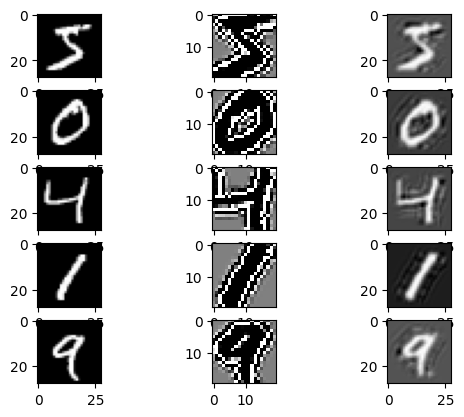

In [93]:
encoder = cae[:6]
decoder = cae[6:]
n = 20
f, ax = plt.subplots(5, 3)
for i in range(5):
    code, transport1 = forward(encoder, x_train[i])
    reconstructed = forward(decoder, code)[0][:,:,0]
    ax[i][0].imshow(x_train[i], cmap='gray')
    ax[i][1].imshow(code[:,:,0], cmap='gray')
    ax[i][2].imshow(reconstructed, cmap='gray')
plt.show()

In [91]:
encoded_train = []
for x in x_train:
    encoded_train.append(forward(encoder, x)[0])
    
encoded_test = []
for x in x_test:
    encoded_test.append(forward(encoder, x)[0])

In [117]:
lap_classifier = create_model([
    ConvResBlock((3,3), input_shape=(n,n,1), output_shape=(n,n,1)),
    ConvResBlock((3,3), input_shape=(n,n,1), output_shape=(n,n,1)),
    # ConvResBlock((3,3), input_shape=(n,n,1), output_shape=(n,n,1)),
    # ConvResBlock((3,3), input_shape=(n,n,1), output_shape=(n,n,1)),
    # ConvResBlock((3,3), input_shape=(4,4,1), output_shape=(4,4,1)),
    # ConvResBlock((3,3), input_shape=(4,4,1), output_shape=(4,4,1)),
    Reshape((1,n**2)),
    Dense(128),
    Tanh(),
    Dense(10),
    Softmax()
], Xavier(), SGD, {'learning_rate': 0.1})
mse = MSE()

x_train, y_train, x_test, y_test = load_data(1000)
lmbda = 100
print('error here includes some measure of average transport costs')
train(lap_classifier, mse, encoded_train, y_train, epochs=15, lmbda=lmbda)
# print('error on test set:', test(lap_classifier, mse, encoded_test, y_test))



error here includes some measure of average transport costs
1/15, error=18.134510
2/15, error=15.661382
3/15, error=13.129618
4/15, error=8.834118
5/15, error=5.964353
6/15, error=5.714920
7/15, error=6.429147
8/15, error=6.884520
9/15, error=7.212113
10/15, error=7.775800
11/15, error=8.394256
12/15, error=8.867675
13/15, error=9.242098
14/15, error=9.617337
15/15, error=10.027559


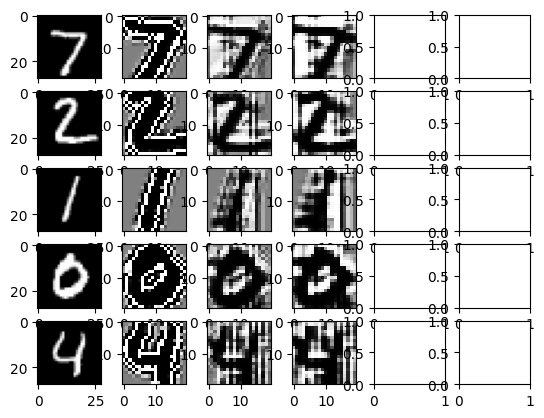

In [118]:
f, ax = plt.subplots(5, 6)
for i in range(5):
    code = forward(encoder, x_test[i])[0]
    # reconstructed = forward(decoder, code)[0]
    block1 = -1*forward(lap_classifier[:1], code)[0]
    block2 = -1*forward(lap_classifier[:2], code)[0]
    # block3 = -1*forward(lap_classifier[:3], code)[0]
    # block4 = -1*forward(lap_classifier[:4], code)[0]
    # reconstructed6 = forward(model2[:5], code)[0]
    ax[i][0].imshow(x_test[i], cmap='gray')
    ax[i][1].imshow(code[:,:,0], cmap='gray')
    ax[i][2].imshow(block1[:,:,0], cmap='gray')
    ax[i][3].imshow(block2[:,:,0], cmap='gray')
    # ax[i][4].imshow(block3[:,:,0], cmap='gray')
    # ax[i][5].imshow(block4[:,:,0], cmap='gray')

plt.show()

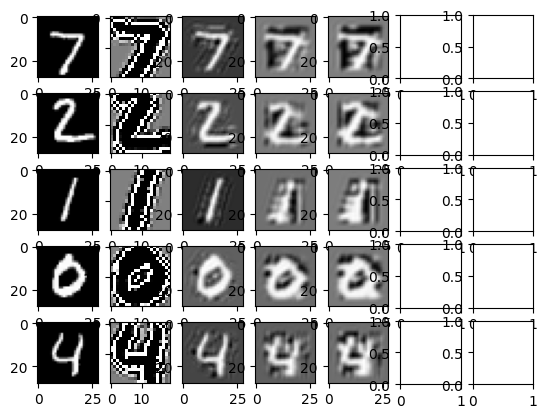

In [119]:
f, ax = plt.subplots(5, 7)
for i in range(5):
    code = forward(encoder, x_test[i])[0]
    block1 = -1*forward(lap_classifier[:1], code)[0]
    block2 = -1*forward(lap_classifier[:2], code)[0]
    block3 = -1*forward(lap_classifier[:3], code)[0]
    block4 = -1*forward(lap_classifier[:4], code)[0]
    reconstructed1 = forward(decoder, code)[0]
    reconstructed2 = forward(decoder, block1)[0]
    reconstructed3 = forward(decoder, block2)[0]
    # reconstructed4 = forward(decoder, block3)[0]
    # reconstructed5 = forward(decoder, block4)[0]
    # reconstructed6 = forward(decoder, forward(model2[:5], code1)[0].reshape(1,16))[0]
    ax[i][0].imshow(x_test[i], cmap='gray')
    ax[i][1].imshow(code[:,:,0], cmap='gray')
    ax[i][2].imshow(reconstructed1[:,:,0], cmap='gray')
    ax[i][3].imshow(reconstructed2[:,:,0], cmap='gray')
    ax[i][4].imshow(reconstructed3[:,:,0], cmap='gray')
    # ax[i][5].imshow(reconstructed4[:,:,0], cmap='gray')
    # ax[i][6].imshow(reconstructed5[:,:,0], cmap='gray')

plt.show()

In [120]:
error = 0
transports = 0
for x, y in zip(encoded_test, y_test):
    (output, transport) = forward(lap_classifier, x)
    transports+= transport
    error += loss.call(y, output[0]) #+ lmbda * transport
error /= len(x_test)
transports /= len(x_test)

print('classification error = %f, average transport cost across residual blocks = %f ' % (error, transports/lmbda))

classificatin error = 0.032801, average transport cost across residual blocks = 0.001082 
